In [1]:
require("lubridate")
require("tidyverse")
require("ggsci")
options(repr.plot.width=12, repr.plot.height=6)

# helpers
save_png = function(plt, dir = "./",width = 1800,height = 800, res = 220) {
  path = paste0(dir,deparse(substitute(plt)),".png")
  message(path)
  png(path, width = width, height = height, res = res)
  plot(plt)
  dev.off()
}

Loading required package: lubridate


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: tidyverse

─ Attaching packages ──────────────────── tidyverse 1.3.0 ─

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

─ Conflicts ───────────────────── tidyverse_conflicts() ─
✖ lubridate::as.difftime() masks base::as.difftime()
✖ lubridate::date()        masks base::date()
✖ dplyr::filter()          masks stats::filter()
✖ lubridate::intersect()   masks base::intersect()
✖ dplyr::lag()             masks stats::lag()
✖ lubridate::setdiff()     masks base::setdiff()
✖ lubridate::union()       masks base::union()

Loading required package: ggsci



In [17]:
df_2 = read_csv(
    './27835219-eo-landing-funnels.csv', 
    na = 'NULL', 
    locale = readr::locale(encoding = "GBK")
)

Parsed with column specification:
cols(
  uid = col_double(),
  time = col_datetime(format = ""),
  action = col_character(),
  milestone_id = col_double(),
  role = col_double(),
  os = col_character(),
  city_level = col_character(),
  channel_user_name = col_character(),
  channel_account_subclass = col_character(),
  camp_page_time = col_datetime(format = ""),
  join_camp_time = col_datetime(format = ""),
  login_page_time = col_datetime(format = ""),
  login_click_time = col_datetime(format = ""),
  login_success_time = col_datetime(format = ""),
  login_failed_time = col_datetime(format = ""),
  group_page_time = col_datetime(format = ""),
  copy_wechat_time = col_datetime(format = ""),
  group_success_time = col_datetime(format = "")
)



In [18]:
# limit funnel time window
df_2 = df_2 %>%
    mutate(
        join_camp_time = as_datetime(ifelse(!is.na(join_camp_time) & !is.na(camp_page_time) & (join_camp_time - camp_page_time <= 60*20) & (join_camp_time - camp_page_time > 0), join_camp_time, NA)),
#         login_page_time = as_datetime(ifelse(!is.na(login_page_time) & !is.na(join_camp_time) & (login_page_time - join_camp_time <= 60*30), login_page_time, NA)),
        login_success_time = as_datetime(ifelse(!is.na(login_success_time) & !is.na(login_page_time) & (login_success_time - login_page_time <= 60*20), login_success_time, NA)),
        group_page_time = as_datetime(ifelse(!is.na(group_page_time) & !is.na(login_success_time) & (group_page_time - login_success_time <= 60*20), group_page_time, NA)),
        copy_wechat_time = as_datetime(ifelse(!is.na(copy_wechat_time) & !is.na(group_page_time) & (copy_wechat_time - group_page_time <= 60*20), copy_wechat_time, NA)),
        group_success_time = as_datetime(ifelse(!is.na(group_success_time) & !is.na(copy_wechat_time) & (group_success_time - copy_wechat_time <= 60*60*24), group_success_time, NA)),
        hour = hour(camp_page_time)
    )

In [31]:
sum(is.na(df_2$copy_wechat_time))

[1] 17788

In [32]:
dim(df_2)

[1] 33536    19

In [19]:
# mapping role
role_mapping = c('未知','上班族','自由职业','大学生','中小学生')
names(role_mapping) = c('0', '1', '2', '3', '4')
df_2$role = role_mapping[as.character(df_2$role)]

df_2$milestone_id[is.na(df_2$milestone_id)] = 0
level_mapping = c('未测试','A1初','A1中','A1高','A2初','A2中','A2高','B1初','B1高','B2','C1','C2')
names(level_mapping) = c('0','21010','21020','21030','22010','22020','22030','23010','23030','24000','25000','26000')
df_2$milestone_id = level_mapping[as.character(df_2$milestone_id)]

In [20]:
# function to generate metrics
gp_2w = function(df, cols, cut=80) {
    df %>% 
    group_by(.dots=all_of(cols)) %>%
    summarise(
        users = n(),
        rate.01_点击报名 = sum(!is.na(join_camp_time))/n(),
        rate.02_登录成功 = sum(!is.na(login_success_time))/sum(!is.na(login_page_time)),
        rate.03_复制微信 = sum(!is.na(copy_wechat_time))/sum(!is.na(group_page_time)),
        rate.04_加群成功 = sum(!is.na(group_success_time))/sum(!is.na(copy_wechat_time)),
        avg_duration.01_点击报名 = median(join_camp_time - camp_page_time, na.rm = T),
        avg_duration.02_登录成功 = median(login_success_time - login_page_time, na.rm = T),
        avg_duration.03_复制微信 = median(copy_wechat_time - group_page_time, na.rm = T),
        avg_duration.04_加群成功 = median(group_success_time - copy_wechat_time, na.rm = T),
        avg_duration.04_加群成功 = median(login_click_time - login_page_time, na.rm = T),
    ) %>% 
    ungroup() %>%
    filter(users >= cut)
}

gp_2l = function(df, cols, cut=80) {
    gp_2w(df, cols, cut) %>%
    pivot_longer(
        cols = -c(users,c(.dots=all_of(cols))),
        names_to = c(".value","step"),
        names_sep = "\\."
    )
}

In [21]:
gp_2w(
    df_2 %>% 
        filter(
            action %in% c('skip_test','exit_test'),
        ), 
    c("action"),
    cut = 10
)

`summarise()` ungrouping output (override with `.groups` argument)



action,users,rate.01_点击报名,rate.02_登录成功,rate.03_复制微信,rate.04_加群成功,avg_duration.01_点击报名,avg_duration.02_登录成功,avg_duration.03_复制微信,avg_duration.04_加群成功
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<drtn>,<drtn>,<drtn>,<drtn>
exit_test,1706,0.4648300,0.7508855,0.8407407,0.2444934,8 secs,19.5 secs,10 secs,8 secs
skip_test,1560,0.4147436,0.8060150,0.7735043,0.3756906,11 secs,15.0 secs,11 secs,7 secs


## EDA

`summarise()` ungrouping output (override with `.groups` argument)

./plot_eo_landing_funnel_2_by_role.png



png 
  2

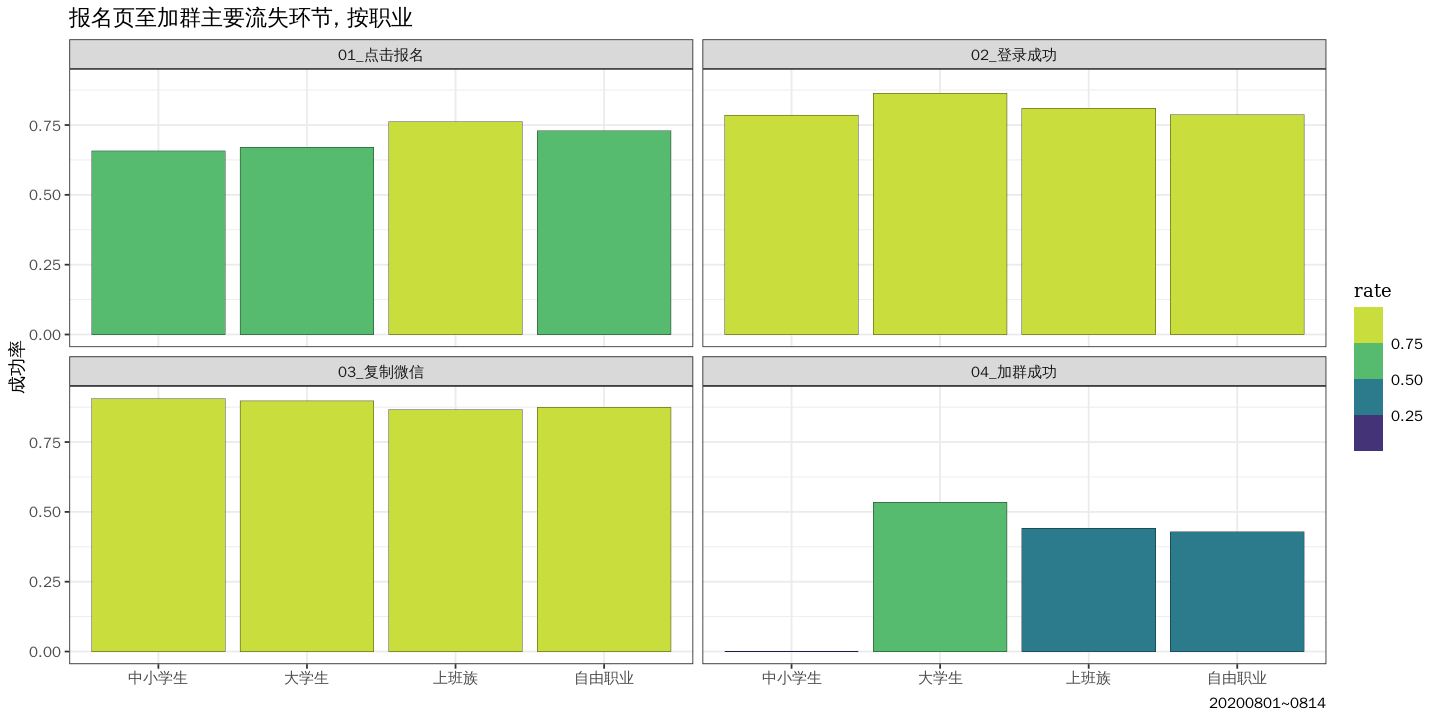

In [22]:
plot_eo_landing_funnel_2_by_role = gp_2l(df_2, c("role"),cut=50) %>%
    filter(role != '未知') %>%
    mutate(role = factor(role, levels = c('中小学生','大学生','上班族','自由职业'))) %>%
    ggplot(aes(x = role, y = rate, fill = rate)) +
    geom_bar(stat = 'identity', color = 'black', lwd = .1) +
    facet_wrap(~step) +
    theme_bw(base_family="serif") +
    # theme(axis.text.x=element_text(angle=45, hjust=1)) +
    #     scale_fill_brewer(palette = "Dark2") +
    scale_fill_viridis_b() + 
    labs(title = '报名页至加群主要流失环节, 按职业', caption = '20200801~0814', x = NULL, y = '成功率')

plot(plot_eo_landing_funnel_2_by_role)
save_png(plot_eo_landing_funnel_2_by_role)

`summarise()` ungrouping output (override with `.groups` argument)

./plot_eo_landing_funnel_2_by_channel.png



png 
  2

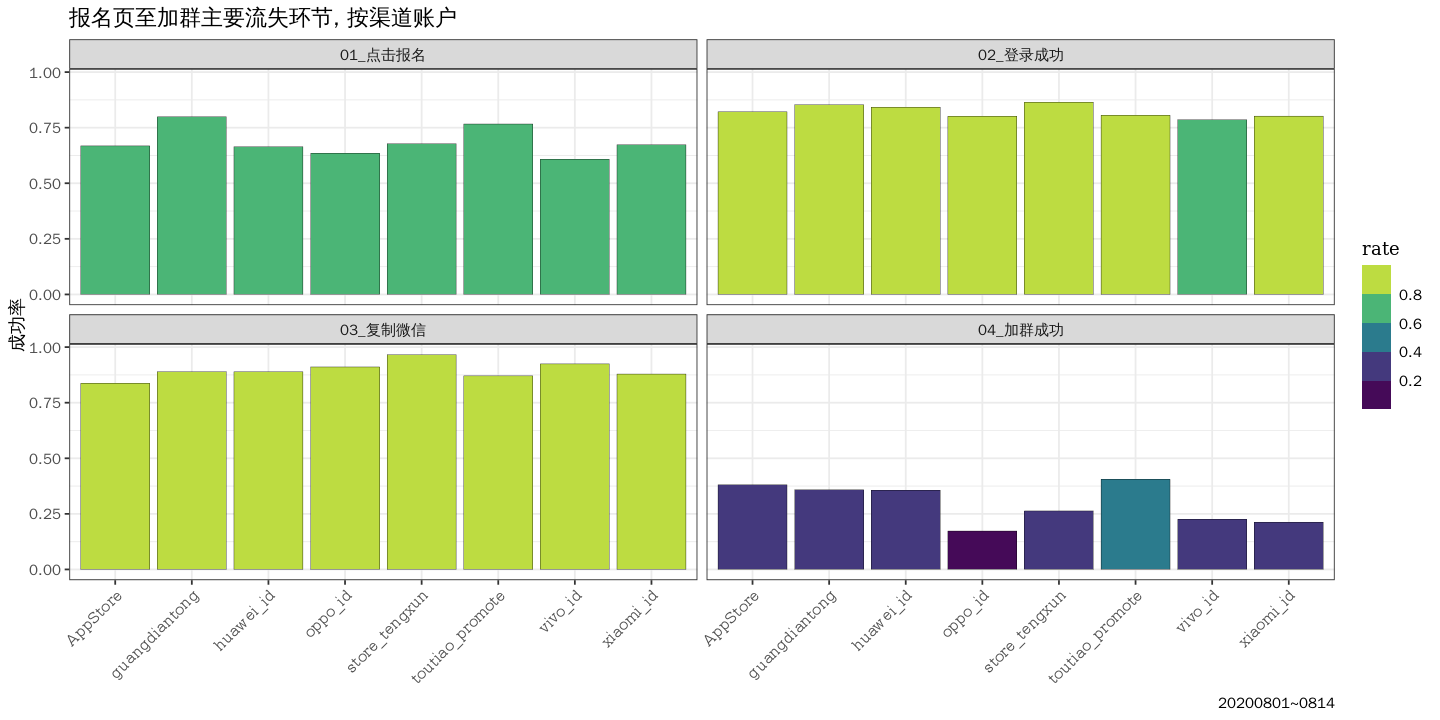

In [23]:
plot_eo_landing_funnel_2_by_channel = gp_2l(df_2, c("channel_user_name"),cut=50) %>%
    ggplot(aes(x = channel_user_name, y = rate, fill = rate)) +
    geom_bar(stat = 'identity', color = 'black', lwd = .1) +
    facet_wrap(~step) +
    theme_bw(base_family="serif") +
    theme(axis.text.x=element_text(angle=45, hjust=1)) +
    #     scale_fill_brewer(palette = "Dark2") +
    scale_fill_viridis_b() + 
    labs(title = '报名页至加群主要流失环节, 按渠道账户', caption = '20200801~0814', x = NULL, y = '成功率')

plot(plot_eo_landing_funnel_2_by_channel)
save_png(plot_eo_landing_funnel_2_by_channel)

`summarise()` regrouping output by 'channel_user_name', 'role' (override with `.groups` argument)

./plot_eo_camp_page_user_dist_by_role.png



png 
  2

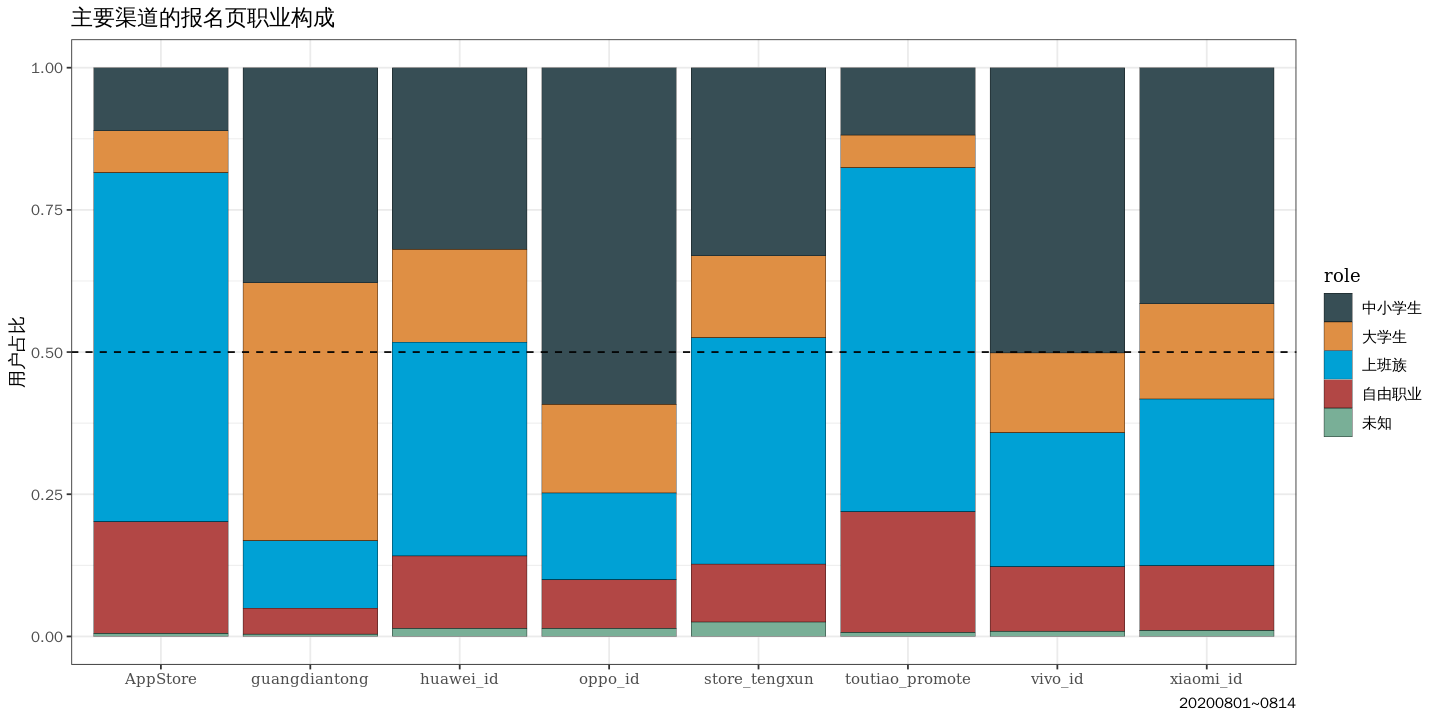

In [24]:
plot_eo_camp_page_user_dist_by_role = df_2 %>% 
    group_by(channel_user_name) %>%
    mutate(user_subtotal = n()) %>%
    filter(user_subtotal >= 50) %>%
    group_by(channel_user_name, role, user_subtotal) %>%
    summarise(users = n()) %>%
    mutate(user_ratio = users / user_subtotal) %>%
    mutate(role = factor(role, levels = c('中小学生','大学生','上班族','自由职业','未知'))) %>%
    ungroup() %>%
    ggplot(aes(x = channel_user_name, y = user_ratio, fill = role)) +
    geom_bar(stat = 'identity', color = 'black', lwd = .1) +
    geom_hline(yintercept = 0.5, linetype = 'dashed') +
    scale_fill_jama() + 
    theme_bw(base_family="serif") +
    labs(title = '主要渠道的报名页职业构成', caption = '20200801~0814', x = NULL, y = '用户占比')

plot(plot_eo_camp_page_user_dist_by_role)
save_png(plot_eo_camp_page_user_dist_by_role)

`summarise()` ungrouping output (override with `.groups` argument)

./plot_eo_landing_funnel_2_by_action.png



png 
  2

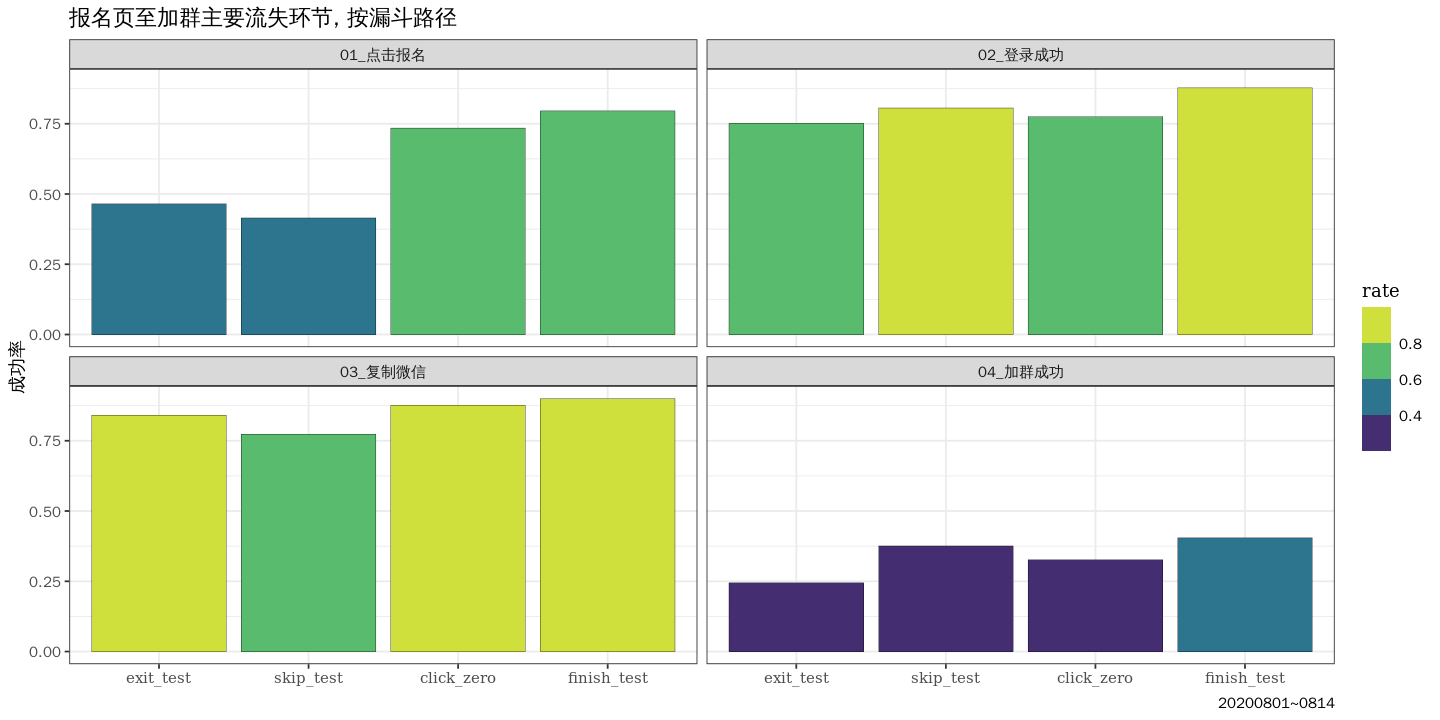

In [25]:
plot_eo_landing_funnel_2_by_action = gp_2l(df_2, c("action"),cut=50) %>%
    mutate(action = factor(action, levels = c('exit_test','skip_test','click_zero','finish_test'))) %>%
    ggplot(aes(x = action, y = rate, fill = rate)) +
    geom_bar(stat = 'identity', color = 'black', lwd = .1) +
    facet_wrap(~step) +
    theme_bw(base_family="serif") +
    # theme(axis.text.x=element_text(angle=45, hjust=1)) +
    #     scale_fill_brewer(palette = "Dark2") +
    scale_fill_viridis_b() + 
    labs(title = '报名页至加群主要流失环节, 按漏斗路径', caption = '20200801~0814', x = NULL, y = '成功率')

plot(plot_eo_landing_funnel_2_by_action)
save_png(plot_eo_landing_funnel_2_by_action)

`summarise()` regrouping output by 'milestone_id' (override with `.groups` argument)

./plot_eo_landing_funnel_2_by_level.png



png 
  2

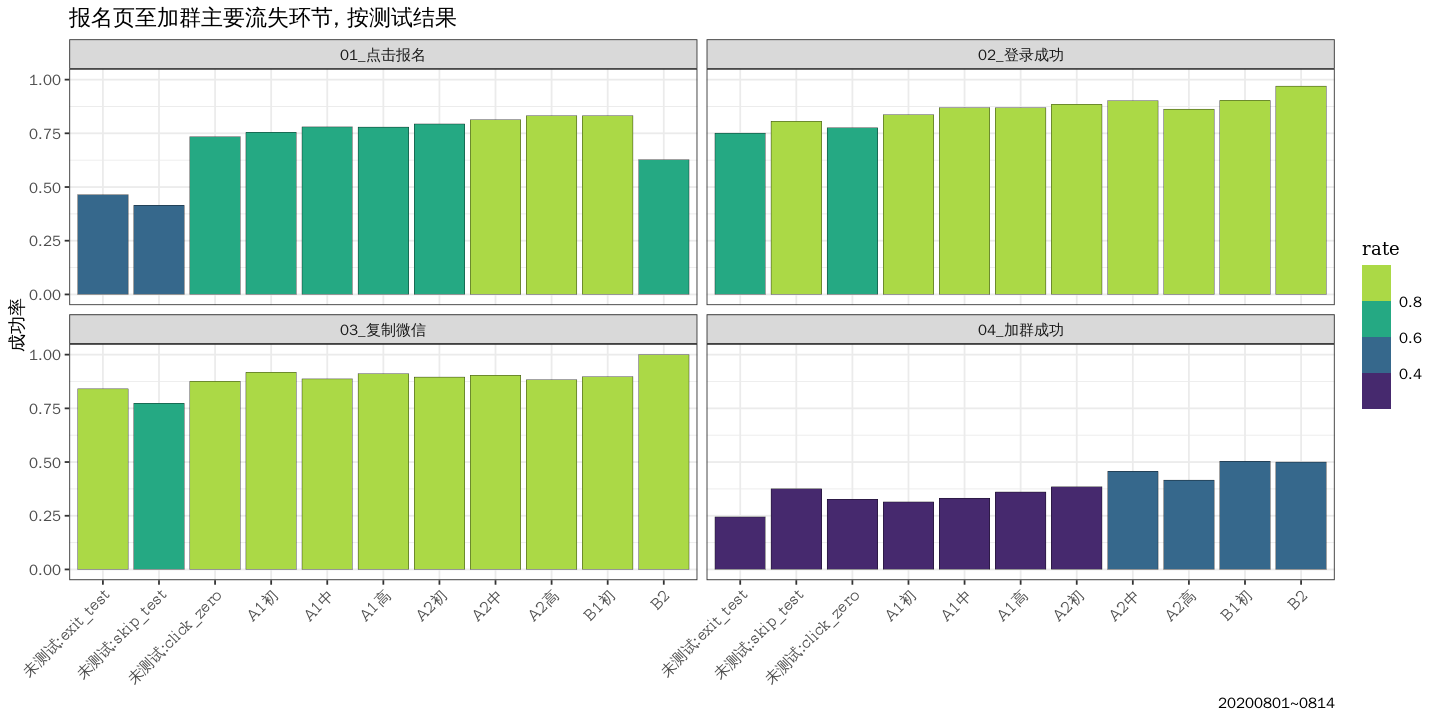

In [26]:
plot_eo_landing_funnel_2_by_level = gp_2l(df_2, c("milestone_id","action"),cut=50) %>%
    mutate(
        level_group = ifelse(grepl('未测试',milestone_id),paste0(milestone_id,':',action),milestone_id),
        level_group = factor(
            level_group,
            levels = c('未测试:exit_test','未测试:skip_test','未测试:click_zero','A1初','A1中','A1高','A2初','A2中','A2高','B1初','B1高','B2','C1','C2')
        )
    ) %>%
    ggplot(aes(x = level_group, y = rate, fill = rate)) +
    geom_bar(stat = 'identity', color = 'black', lwd = 0.1) +
    facet_wrap(~step) +
    theme_bw(base_family="serif") +
    theme(axis.text.x=element_text(angle=45, hjust=1)) +
    #     scale_fill_brewer(palette = "Dark2") +
    scale_fill_viridis_b() + 
    labs(title = '报名页至加群主要流失环节, 按测试结果', caption = '20200801~0814', x = NULL, y = '成功率')

plot(plot_eo_landing_funnel_2_by_level)
save_png(plot_eo_landing_funnel_2_by_level)

`summarise()` regrouping output by 'hour' (override with `.groups` argument)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

./plot_eo_landing_funnel_2_by_hour.png

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



png 
  2

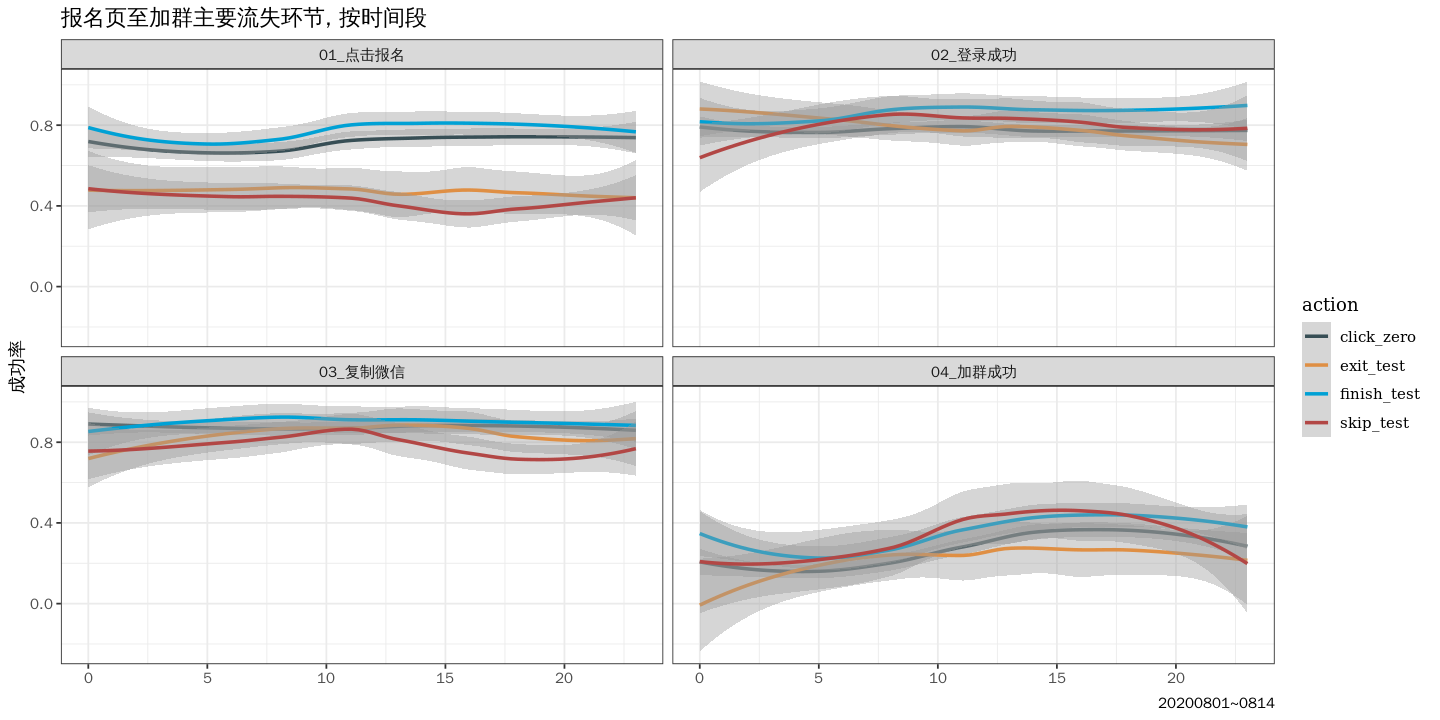

In [27]:
plot_eo_landing_funnel_2_by_hour = gp_2l(df_2, c("hour","action"),cut=10) %>%
    ggplot(aes(x = hour, y = rate, group = action, color = action)) +
    geom_smooth() +
    facet_wrap(~step) +
    theme_bw(base_family="serif") +
    scale_color_jama() +
    labs(title = '报名页至加群主要流失环节, 按时间段', caption = '20200801~0814', x = NULL, y = '成功率')

plot(plot_eo_landing_funnel_2_by_hour)
save_png(plot_eo_landing_funnel_2_by_hour)